### 1. Dependencies

In [ ]:
#pip install torch torchvision transformers datasets

### 2. Load SQuAD Dataset

In [24]:
from datasets import load_dataset
squad_dataset = load_dataset('squad')


### 3. Preprocess Data, Training and Testing

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/owner/anaconda3/envs/venv38/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 completed, Loss: 5.723166465759277
Epoch 2/10 completed, Loss: 3.8834476470947266
Epoch 3/10 completed, Loss: 3.456273078918457
Epoch 4/10 completed, Loss: 2.472014904022217
Epoch 5/10 completed, Loss: 2.075420618057251
Epoch 6/10 completed, Loss: 1.832597255706787
Epoch 7/10 completed, Loss: 1.460591435432434
Epoch 8/10 completed, Loss: 1.535317301750183
Epoch 9/10 completed, Loss: 1.1461172103881836
Epoch 10/10 completed, Loss: 1.0559332370758057
Training completed.


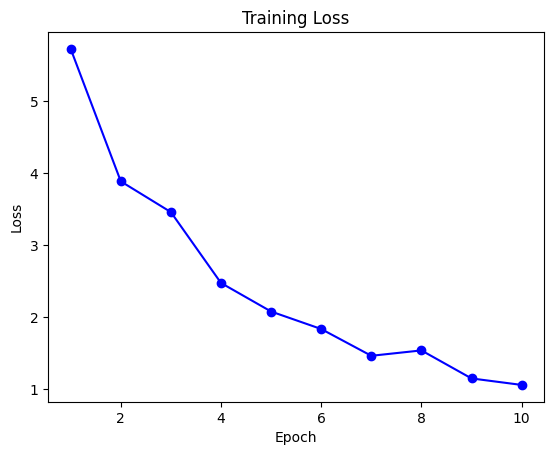

In [25]:
import matplotlib.pyplot as plt
import json
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForQuestionAnswering, AdamW

# Function to Load Dataset
def load_squad_dataset(file_path):
    with open(file_path, 'r') as file:
        squad_dict = json.load(file)
    return squad_dict

# Function to Tokenize and Prepare Dataset
def tokenize_squad_data(squad_data, tokenizer):
    inputs = []
    targets_start = []
    targets_end = []

    for article in squad_data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                answer = qa['answers'][0]
                answer_text = answer['text']
                start_char = answer['answer_start']
                end_char = start_char + len(answer_text)

                # Tokenize context and question
                tokenized_input = tokenizer.encode_plus(question, context, max_length=384, truncation=True, padding='max_length', return_tensors='pt')
                input_ids = tokenized_input['input_ids'].squeeze()

                # Find positions of answer tokens
                start_token = len(tokenizer.encode(question, add_special_tokens=False)) + 1
                end_token = start_token + len(tokenizer.encode(answer_text, add_special_tokens=False))

                inputs.append(input_ids)
                targets_start.append(start_token)
                targets_end.append(end_token)

    return torch.stack(inputs), torch.tensor(targets_start), torch.tensor(targets_end)

# Define Custom Dataset
class SquadDataset(Dataset):
    def __init__(self, encodings, start_positions, end_positions):
        self.encodings = encodings
        self.start_positions = start_positions
        self.end_positions = end_positions

    def __getitem__(self, idx):
        return {"input_ids": self.encodings[idx], 
                "start_positions": self.start_positions[idx], 
                "end_positions": self.end_positions[idx]}

    def __len__(self):
        return len(self.encodings)

# Load SQuAD Dataset
squad_dataset = load_squad_dataset('sample_squad_data.json')

# Initialize Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and Prepare Dataset
inputs, start_positions, end_positions = tokenize_squad_data(squad_dataset, tokenizer)

# Create Dataset and DataLoader
dataset = SquadDataset(inputs, start_positions, end_positions)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize Model
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 10
loss_values = []  # List to store loss values

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids=input_ids, start_positions=start_positions, end_positions=end_positions)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate the average loss over the epoch and store it
    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs} completed, Loss: {avg_loss}')

print("Training completed.")

# Plotting the training loss
plt.plot(range(1, num_epochs+1), loss_values, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [26]:
# Example context and question
context = "The Eiffel Tower was constructed from 1887 to 1889."
question = "When was the Eiffel Tower completed?"

# Use pipeline to make a prediction
answer = qa_pipeline(question=question, context=context)

print(f"Question: {question}")
print(f"Answer: {answer['answer']}")

Question: When was the Eiffel Tower completed?
Answer: 1889.
